In [23]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import scvi

%load_ext autoreload
%autoreload 2

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpex8kcqlc
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpex8kcqlc/_remote_module_non_scriptable.py
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this tutorial, we demonstrate how to analyse (near single cell) stereo-seq mouse brain data

In [2]:
adata = sc.read_h5ad("../../../../spatialLDA/spatiallda/reproducibility/figure2/data/Lung12.h5ad")
adata.var_names_make_unique()

In [3]:
adata.obsm['spatial'] = adata.obsm['spatial_raw']

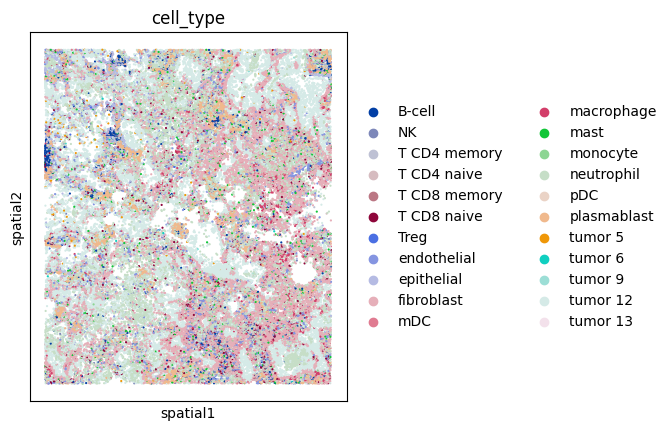

In [4]:
sc.pl.spatial(adata, spot_size = 0.03, color = 'cell_type')

In [5]:
sc.pp.filter_cells(adata, min_genes=30)
sctm.pp.filter_genes(adata, 0.01,  expression_cutoff_99q = 0)
sc.pp.highly_variable_genes(adata, n_top_genes=600, flavor="seurat_v3")

In [6]:
sq.gr.spatial_neighbors(adata)

In [24]:
scvi.model.SCVI.setup_anndata(adata)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [29]:
model = scvi.model.SCVI(adata, n_layers =2, n_latent = 30)
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/117:   3%|██▍                                                                     | 4/117 [00:26<12:37,  6.70s/it, v_num=1, train_loss_step=369, train_loss_epoch=441]

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [22]:
n_topics = 15
# 
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
    beta = 0.1,
    batch_size = 128
)

# uses gpu by default to use cpu use device="cpu"
model.train(learning_rate = 0.01)

Computing background frequencies
Layer (type:depth-idx)                   Param #
OptimizedModule                          --
├─spatialLDAModel: 1-1                   --
│    └─MLPEncoderMVN: 2-1                --
│    │    └─Dropout: 3-1                 --
│    │    └─BatchNorm1d: 3-2             2,400
│    │    └─BatchNorm1d: 3-3             100
│    │    └─BatchNorm1d: 3-4             --
│    │    └─Linear: 3-5                  765
│    │    └─Linear: 3-6                  765
│    │    └─Linear: 3-7                  5,355
│    │    └─Linear: 3-8                  60,050
Total params: 69,435
Trainable params: 69,435
Non-trainable params: 0


Loss:249.420:   0%|▏                                                                                                                      | 4/2000 [02:58<24:41:13, 44.53s/it]

KeyboardInterrupt



In [ ]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

In [ ]:
sc.pl.spatial(adata, color = topic_prop.columns, spot_size = 0.03, vmax = 'p99')

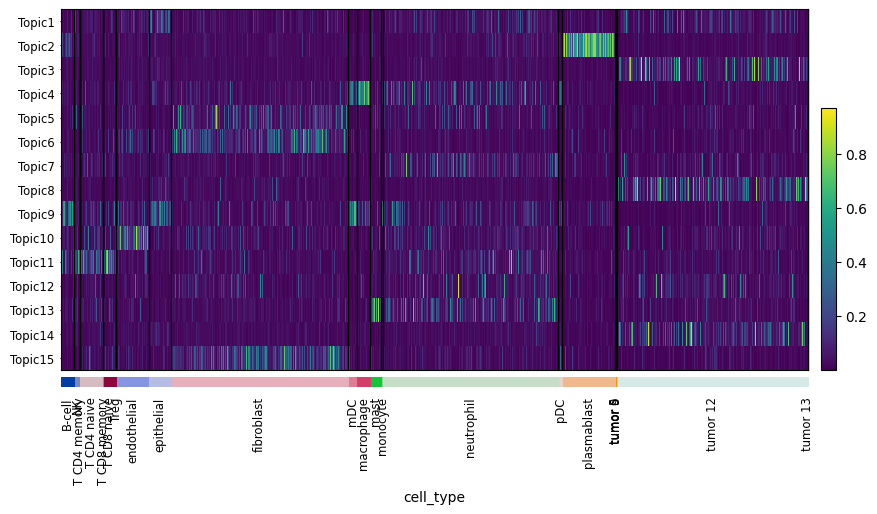

In [13]:
sctm.pl.heatmap(adata, topic_prop, groupby = "cell_type")